# Lab 3: Gaussian Process Regression
## Short Course on Statistical Models for optimization

In [1]:
import matplotlib as mpl
mpl.use("pgf")
pgf_with_pdflatex = {
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": [
         r"\usepackage[utf8x]{inputenc}",
         r"\usepackage[T1]{fontenc}",
         r"\usepackage{cmbright}",
         ]
}
mpl.rcParams.update(pgf_with_pdflatex)
import matplotlib.pyplot as plt

% pylab inline
import numpy as np
import pandas as pd
import pylab as pb
import GPy
import seaborn as sns
pb.ion()


sns.set_context("paper")


Populating the interactive namespace from numpy and matplotlib


 /Users/juangilopez/anaconda/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning:The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.


This lab will b developed using the time measurements taken with the helicopters created in the second Lab(Design of experiments). First we'll analize de gathered data to determine the noise and some other correlations.

In [2]:
df = pd.read_csv('helicopterTrials.csv',names=['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2'])
#print type(df)
#sns.pairplot(df)

The next plots show the noise of the measurements made by two observers for the same throw of an helicopter, One can see that between observers there is not much noise:

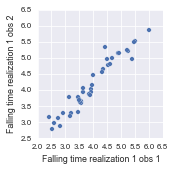

In [3]:
sns.pairplot(df, x_vars=['Ex1O1'], y_vars=['Ex1O2'])
plt.xlabel('Falling time realization 1 obs 1')
plt.ylabel('Falling time realization 1 obs 2')
plt.savefig('Ex1O1_vs_Ex1O2.pgf')

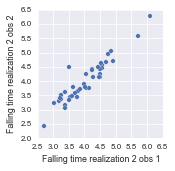

In [4]:
sns.pairplot(df, x_vars=['Ex2O1'], y_vars=['Ex2O2'])
plt.xlabel('Falling time realization 2 obs 1')
plt.ylabel('Falling time realization 2 obs 2')
#plt.savefig('Ex2O1_vs_Ex2O2.pgf')

However the next plots show other behavior, the measurements are noise between throws, mabe because the weather conditions and some other external factors:

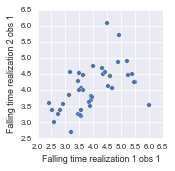

In [5]:
sns.pairplot(df, x_vars=['Ex1O1'], y_vars=['Ex2O1'])
plt.xlabel('Falling time realization 1 obs 1')
plt.ylabel('Falling time realization 2 obs 1')
plt.savefig('Ex1O1_vs_Ex2O1.pgf')

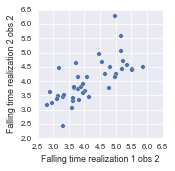

In [6]:
sns.pairplot(df, x_vars=['Ex1O2'], y_vars=['Ex2O2'])
plt.xlabel('Falling time realization 1 obs 2')
plt.ylabel('Falling time realization 2 obs 2')
#plt.savefig('Ex1O2_vs_Ex2O2.pgf')

After some further analysis it was decided to use the average of the four time measurements to train the GP model.

In [7]:
exp1 = np.array(df[['Ex1O1', 'Ex1O2']])
exp2 = np.array(df[['Ex2O1', 'Ex2O2']])
superexp = np.array(df[['Ex1O1', 'Ex1O2', 'Ex2O1', 'Ex2O2']])
exp1 = np.mean(exp1, axis=1)
exp2 = np.mean(exp2, axis=1)
data = np.loadtxt('X.csv', delimiter=',')
exp1 = exp1[:,None]
exp2 = exp2[:,None]
data = np.hstack((data[0:40,:], np.mean(superexp, axis=1)[:,None]))

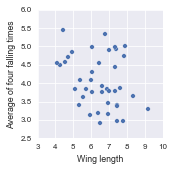

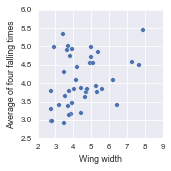

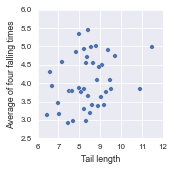

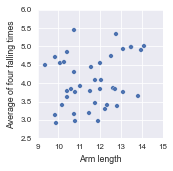

In [8]:
names = ["Wing-length", "Wing-width", "Tail-length", "Arm-length", "T1"]
df = pd.DataFrame(data=data, columns=names)
#sns.pairplot(dataplot)

sns.pairplot(df, x_vars=['Wing-length'], y_vars=['T1'])
plt.xlabel('Wing length')
plt.ylabel('Average of four falling times')
#plt.savefig('wl_vs_t.pgf')

sns.pairplot(df, x_vars=['Wing-width'], y_vars=['T1'])
plt.xlabel('Wing width')
plt.ylabel('Average of four falling times')
#plt.savefig('ww_vs_t.pgf')

sns.pairplot(df, x_vars=['Tail-length'], y_vars=['T1'])
plt.xlabel('Tail length')
plt.ylabel('Average of four falling times')
#plt.savefig('tl_vs_t.pgf')

sns.pairplot(df, x_vars=['Arm-length'], y_vars=['T1'])
plt.xlabel('Arm length')
plt.ylabel('Average of four falling times')
#plt.savefig('al_vs_t.pgf')

The Correlations between the printing space variables are not evident, then it's neccesary to convert the input variables to other space in order to see the correlations and help the Gaussian process model to make an accurate regression

In [17]:
##################################################################
##                           helpers                            ##
##################################################################

## coordinate change

def angle(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output is the angle (in degrees) between the tail and the wing
    return(180/np.pi*np.arccos(-1.*((X[:,3]-2.5)**2-(X[:,2]-2.5)**2-X[:,0]**2)/(2*(X[:,2]-2.5)*X[:,0])))

# mapping to the new space
def old2new(X):
    # input X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    # output Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    Y = 0*X
    Y[:,0] = angle(X)
    Y[:,1] = X[:,0] * X[:,1]  
    Y[:,2] = X[:,0] + X[:,2] + X[:,3] 
    Y[:,3] = X[:,0] / (X[:,2] - 2.5)
    return(Y)

# mapping back to the original space
def new2old(Y):
    # input Y is ['wing angle', 'wing area','total length', 'wing_l / tail_l ratio']
    # output X is ["Wing-length", "Wing-width", "Tail-length", "Arm-length"]
    X = 0*Y
    f_1 = np.sqrt(1+(1/Y[:,3])**2-2*np.cos(Y[:,0]*np.pi/180)*(1/Y[:,3]))
    X[:,0] = (Y[:,2]-5) / (1 + 1./Y[:,3] + f_1)
    X[:,1] = Y[:,1] / X[:,0]
    X[:,2] = X[:,0] / Y[:,3] + 2.5
    X[:,3] = Y[:,2] - X[:,0] - X[:,2]
    return(X)

## error measures

def Q2(F,mX):
    return(1-sum((F-mX)**2)/sum((F-np.mean(F))**2))

def StandResiduals(F,mx,var):
    A = F.flatten() - mx.flatten()
    B = np.sqrt(var)
    ret = np.divide(A,B)
    return ret

def leaveOneOut(m):
    n = m.X.shape[0]
    mean = np.zeros(n)
    var = np.zeros(n)
    kern = m.kern
    for i in range(n):
        Xloo = np.delete(m.X,i,0)
        Yloo = np.delete(m.Y,i,0)
        mloo = GPy.models.gp_regression.GPRegression(Xloo, Yloo, kern.copy())
        mloo[:] = m[:]
        mean[i],var[i] = mloo.predict(X[i:i+1,:])
    return(mean,var)

Data transformation from the printing space to the new space in which the mode will be trained:

In [10]:
##############################
# Question 1 

# load data Data Transformation
#data = # TODO: load your data here

X = data[:,0:4]#,data[:,0:4]))
F = data[:,4:5]#,data[:,5:6]))

n, d = X.shape

## choose the new parameterization and rescale for convenience
X =  old2new(X)
limits = np.array([75,115,20,35,22,31,0.65,1.6]).reshape(4,2).T
X = (X-limits[0:1,:])/(limits[1:2,:]-limits[0:1,:])

F = F-np.mean(F)

# look at noise variance
tau2 = 0.01#np.var(data[:,4]-data[:,5])/2.

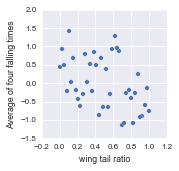

In [11]:
data[:,0:4] = X #+ 1.0 to avoid bug with pgf in latex
data[:,4:5] = F
df = pd.DataFrame(data=data, columns=['wing-angle', 'wing-area','total-length', 'wing-l-tail-l-ratio', 'T1'])

#sns.pairplot(df, x_vars=['wing-angle'], y_vars=['T1'])
#plt.xlabel('wing angle')
#plt.ylabel('Average of four falling times')
#plt.savefig('wang_vs_t.pgf')

#sns.pairplot(df, x_vars=['wing-area'], y_vars=['T1'])
#plt.xlabel('wing area')
#plt.ylabel('Average of four falling times')
#plt.savefig('war_vs_t.pgf')

#sns.pairplot(df, x_vars=['total-length'], y_vars=['T1'])
#plt.xlabel('total length')
#plt.ylabel('Average of four falling times')
#plt.savefig('totl_vs_t.pgf')

sns.pairplot(df, x_vars=['wing-l-tail-l-ratio'], y_vars=['T1'])
plt.xlabel('wing tail ratio')
plt.ylabel('Average of four falling times')
plt.savefig('wtr_vs_t.pgf')

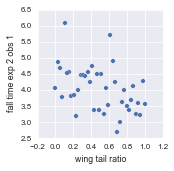

In [12]:
XX = X
data = np.hstack((XX,superexp))
df = pd.DataFrame(data=data, columns=['wing-angle', 'wing-area','total-length', 'wing_l/tail_l-ratio', 'T1', 'T2', 'T3', 'T4'])

sns.pairplot(df, x_vars=['wing_l/tail_l-ratio'], y_vars=['T3'])
plt.xlabel('wing tail ratio')
plt.ylabel('fall time exp 2 obs 1')
plt.savefig('wtr_vs_fte2o1.pgf')

In the the two plots showed above it can be shown that taking the average of the four time measurements instead of each individual measure improves the correlation, for example, the linear incresing correlation between the wing tail ratio and the falling time is more evident using the average of the four falling times.

The GP model proposed below in this case uses the sum of tree covariances funcions.

In [13]:
##############################
# Question 2

# define a kernel
def GPreg(X, F, d):
    kern0 = GPy.kern.Matern32(input_dim=d,variance=np.var(F),lengthscale=[.5]*d,ARD=True)
    kern1 = GPy.kern.RBF(input_dim=d,variance=0.01,lengthscale=[.1]*d,ARD=True)
    kern2 = GPy.kern.RBF(input_dim=d,variance=0.05,lengthscale=[.5]*d,ARD=True)
    kern = kern0 + kern1 + kern2
    #print kern
    #kern['.*lengthscale'] # get more details about length-scales
    # define a model
    m = GPy.models.gp_regression.GPRegression(X, F, kern)
    #print m
    # optimize the model parameters
    m.optimize()
    #m.optimize_restarts(num_restarts=10)
    #print m
    #m['.*lengthscale']
    return m

# predict at points Xnew
m = GPreg(X, F, d)
Xnew = np.random.uniform(0,1,(3,d))
Xnew = Xnew*(np.max(X,axis=0)-np.min(X,axis=0)) + np.min(X,axis=0)
mean, var = m.predict(Xnew)
print(mean)
print("IMSE = %f" % round(np.mean(var),2))

[[-0.34847067]
 [-0.58147569]
 [ 0.21992985]]
IMSE = 0.240000


The leave one out function was written to evaluate the model ability to predict new data, for this case the $Q2$ is 0.5 aproximately, which represents a good value for the model and allow us to proceed with this model to the optimization stage.

0.572984103679
Standarized Residuals: 
[ 0.7923654  -0.46962302  1.64211163 -0.5461551  -0.92567525 -1.26857003
 -0.57489262  0.39549507  1.20363025 -1.43916999 -0.38583125 -0.58092717
  1.02594333 -0.56947295 -0.20165349  0.27811672  1.27995593 -1.03096176
 -0.8166248   0.84261647 -1.02542571 -0.70319953  1.54445115 -0.49940168
  0.18392159  1.17574361 -1.25064935  0.49776064 -1.03200309  1.89706234
 -1.10840316  0.76237473  0.53765481  0.07842723 -0.21019762 -1.40665152
  0.88035206  1.14753634 -0.7770794   0.1974484 ]


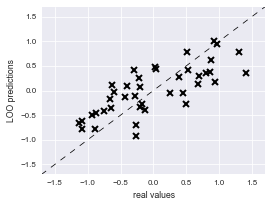

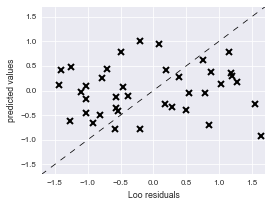

In [29]:
##############################
# Question 3

def OurLeaveOneOut(X,F,d):
    N = X.shape[0]
    limit = N#/2
    ret = np.zeros((N,2))
    m = GPreg(X, F, d)
    kern = m.kern
    for i in range(0,limit):
        idx = np.ones(N, dtype=bool)
        idx[i] = 0
        #idx[i + limit] = 0
        X_train = X[idx, :]
        F_train = F[idx, :]
        mloo = GPy.models.gp_regression.GPRegression(X_train, F_train, kern.copy())
        mloo[:] = m[:]
        idx_test = np.logical_not(idx)
        Xtest = X[idx_test,:]
        #print Xtest
        mean, var = mloo.predict(Xtest)
        ret[i,0] = mean[0,0]
        ret[i,1] = var[0,0]
    
    return ret[:,0][:,None], ret[:,1][:,None]
    
#mloo, vloo = OurLeaveOneOut(X,F,d)# TODO: write "leave two out " function and compute predictions
#print mloo.shape, vloo.shape
m = GPreg(X, F, d)
mloo, vloo = leaveOneOut(m)
print Q2(F.flatten(),mloo.flatten())
SR = StandResiduals(F, mloo, vloo)
print 'Standarized Residuals: '
print SR


pb.figure(1, figsize=(4,3))
pb.plot(F,mloo,'kx',mew=2)
pb.plot((-2,2),(-2,2),'k--',linewidth=.75)
pb.xlim((-1.7,1.7)), pb.ylim((-1.7,1.7))
pb.xlabel('real values'),pb.ylabel('LOO predictions')
plt.savefig('mloovsreal.pgf')

pb.figure(2, figsize=(4,3))
pb.plot(SR, mloo,'kx',mew=2)
pb.plot((-2,2),(-2,2),'k--',linewidth=.75)
pb.xlim((-1.7,1.7)), pb.ylim((-1.7,1.7))
pb.xlabel('Loo residuals'),pb.ylabel('predicted values')
plt.savefig('mlooresidualsvsreal.pgf')

In [53]:
print(m)


Name                              : GP regression
Log-likelihood                    : -33.0189212519
Number of Parameters              : 16
Number of Optimization Parameters : 16
Updates                           : True
Parameters:
  GP_regression.           |        Value        |  Constraint  |  Prior  |  Tied to
  sum.Mat32.variance       |     0.254062221276  |     +ve      |         |         
  sum.Mat32.lengthscale    |               (4,)  |     +ve      |         |         
  sum.rbf_1.variance       |      0.21556565207  |     +ve      |         |         
  sum.rbf_1.lengthscale    |               (4,)  |     +ve      |         |         
  sum.rbf.variance         |    0.0676302750534  |     +ve      |         |         
  sum.rbf.lengthscale      |               (4,)  |     +ve      |         |         
  Gaussian_noise.variance  |  1.23195228302e-15  |     +ve      |         |         
